In [1]:
from skimage import data, io, filters
import cv2
import os
import requests
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = os.getcwd()
filename = 'pic.jpg'
my_image = io.imread(os.path.join(path, filename))/255.0 # image intensity need to be float


In [3]:
my_image.shape

(960, 640, 3)

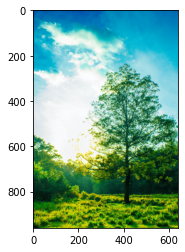

In [4]:
plt.imshow(my_image)
plt.show()

### When we have title box, the range of color intensities inside box can be varied a lot and if we have dynamic subtitle inside box with reverse color of background image, the dynamic subtitle color may not be appropriate when frame of video change. So we first replace intensities outliers with higher frequent intensities (mean of intensities). 
### We have hyper-parameter alpha which is indicating distance from mean intensity expressed by variance that we would like to determine as outlier intensities.  

In [9]:
def smoothing_title_box(my_image, subtitle_position_height0, subtitle_position_height1,subtitle_position_width0,subtitle_position_width1, alpha = 1):
    # subtitle_position_height0, subtitle_position_height1,subtitle_position_width0,subtitle_position_width1 = 130, 146, 150,550
    im_h, im_w = abs(subtitle_position_height1-subtitle_position_height0) , abs(subtitle_position_width1 - subtitle_position_width0)
    bl_h, bl_w = 8, 8
    #alpha is number of standard deviation from mean intensity of block (bl_h, bh_w) which we wants remove the outlayer intensities from orginal image.   
    dct_after_std_all_blocks = np.zeros(my_image.shape)
    for channel in range(3):
        for row in np.arange(im_h - bl_h + 1, step=bl_h):
            for col in np.arange(im_w - bl_w + 1 , step = bl_w):
                block = my_image[subtitle_position_height0 + row:subtitle_position_height0 + row + bl_h, subtitle_position_width0 + col:subtitle_position_width0 + col + bl_w, channel].copy()
                block[np.logical_or((block > np.mean(block) + alpha*np.std(block)), (block < np.mean(block)-alpha*np.std(block)))] = np.mean(block)
                dct_after_std_all_blocks[subtitle_position_height0 + row :subtitle_position_height0 + row + bl_h, subtitle_position_width0 + col :subtitle_position_width0 + col + bl_w, channel] = cv2.dct(block)

    idct_after_std_all_blocks = np.zeros(my_image.shape)    
    for channel in range(3):
        for row in np.arange(im_h - bl_h + 1, step=bl_h):
          for col in np.arange(im_w - bl_w + 1 , step = bl_w):  
              idct_after_std_all_blocks[subtitle_position_height0 + row: subtitle_position_height0 + row + bl_h, subtitle_position_width0 + col : subtitle_position_width0 + col + bl_w, channel] = cv2.idct(dct_after_std_all_blocks[subtitle_position_height0 + row :subtitle_position_height0 + row + bl_h, subtitle_position_width0 + col: subtitle_position_width0 + col+bl_w, channel])          
    
    new_image = my_image.copy()
    new_image[subtitle_position_height0 : subtitle_position_height1,subtitle_position_width0 : subtitle_position_width1, :] = idct_after_std_all_blocks[subtitle_position_height0 : subtitle_position_height1,subtitle_position_width0 : subtitle_position_width1, :]
    color = [0, 0, 0]
    new_image[subtitle_position_height0 : subtitle_position_height0 + 1, subtitle_position_width0 : subtitle_position_width1 , :] = color
    new_image[subtitle_position_height1 -1 : subtitle_position_height1 , subtitle_position_width0 : subtitle_position_width1 , :] = color    
    new_image[ subtitle_position_height0 : subtitle_position_height1, subtitle_position_width0 : subtitle_position_width0 + 1 , :] = color    
    new_image[ subtitle_position_height0 : subtitle_position_height1, subtitle_position_width1 -1 : subtitle_position_width1 , :] = color    
    # font = cv2.FONT_HERSHEY_SIMPLEX
    # cv2.putText(new_image, 'Ayman', (subtitle_position_height0,subtitle_position_width0), font, 3, (0, 255, 0), 2, cv2.LINE_AA)
    # cv2.imwrite( os.getcwd() + 'new_pic.jpg', new_image)
    # image = cv2.rectangle(new_image, (subtitle_position_height0,subtitle_position_width0), (subtitle_position_height1,subtitle_position_width1), (36,255,12), 1)
    # cv2.putText(image, 'Digital Image Processing',(subtitle_position_height0,subtitle_position_width0), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(my_image, cmap='gray'); ax1.title.set_text('original')
    ax2.imshow(new_image, cmap='gray'); ax2.title.set_text('after smooting outlayers')
    fig.suptitle('the averaging the image which has higher or lower value than {alpha} standard deviation from mean')
    plt.show()
    # return new_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


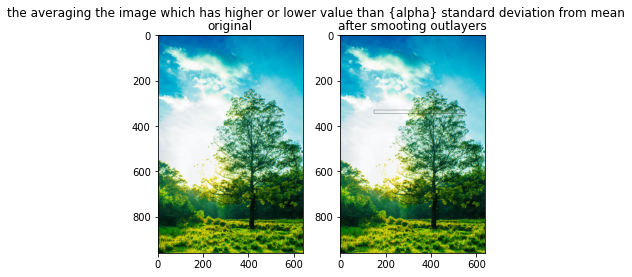

In [10]:
smoothing_title_box(my_image, 330, 346 , 150, 550, alpha= 1.5) #### the range of box need to be multipy of 8 [130, (130 + 8*2), 150: (150 + 8 * 50)] 


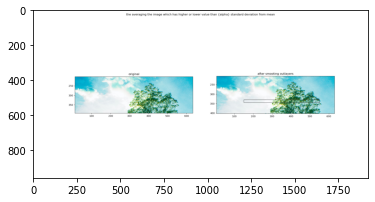

In [12]:
filename = 'pic_out.png'
my_image = io.imread(os.path.join(path, filename))
plt.imshow(my_image)
plt.show()

In [ ]:
video_name = 'out.avi'
cap = cv2.VideoCapture(os.path.join(path, video_name))

count = 0
while cap.isOpened():
    ret,frame = cap.read()
    cv2.imshow('window-name', frame)
    cv2.imwrite("frame%d.jpg" % count, frame)
    count = count + 1
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows() # destroy all opened windows